In [2]:
import numpy as np
import pandas as pd

import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc


#### Load Dataset

In [3]:
data = pd.read_csv('Social_Network_Ads.csv')

In [4]:
print(data.head(), '\n')
print(data.info())

    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB
None


#### Code Categorical Variable: Gender

In [5]:
def code_gender(gender):
    if gender == 'Male':
        return 0
    elif gender == 'Female':
        return 1
    else:
        return -1  # Handle other cases if needed

data['Gender_code'] = data['Gender'].apply(code_gender)

#### Normalize Data: EstimatedSalary & Age

In [8]:
scaler = MinMaxScaler()
data['NormalizedSalary'] = scaler.fit_transform(data[['EstimatedSalary']])
data['NormalizedAge'] = scaler.fit_transform(data[['Age']])

#### Examine Correlation Matrix

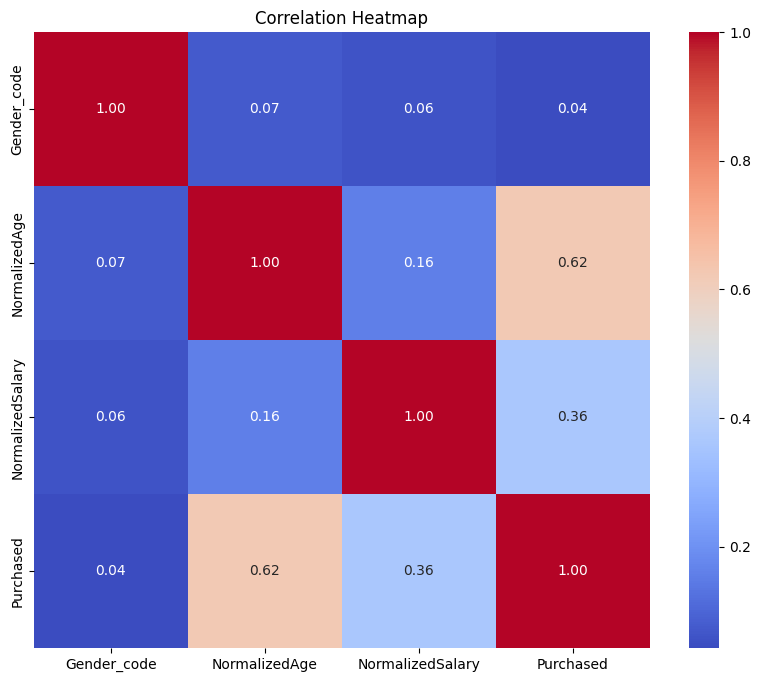

In [9]:
df = data[['Gender_code', 'NormalizedAge', 'NormalizedSalary', 'Purchased']]
corr_matrix = np.corrcoef(df.values, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, xticklabels=df.columns, yticklabels=df.columns)
plt.title("Correlation Heatmap")
plt.show()

#### Correlation Matrix of Features as Dataset

In [10]:
correlation_matrix = df.corr()
correlation_df = pd.DataFrame(correlation_matrix, columns=df.columns, index=df.columns)
print(correlation_df)

                  Gender_code  NormalizedAge  NormalizedSalary  Purchased
Gender_code          1.000000       0.073741          0.060435   0.042469
NormalizedAge        0.073741       1.000000          0.155238   0.622454
NormalizedSalary     0.060435       0.155238          1.000000   0.362083
Purchased            0.042469       0.622454          0.362083   1.000000


<hr>

### Logistic Regression Model

#### Create Train/Test Set


In [11]:
X = df[['Gender_code', 'NormalizedAge', 'NormalizedSalary']]
y = df[['Purchased']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#### Define & Train model

In [12]:
model = LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
model.fit(X_train, y_train)

#### Evaluate Model Performance

In [14]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print('Accuracy on trainset:', train_accuracy)
print('Accuracy on testset:', test_accuracy)

Accuracy on trainset: 0.825
Accuracy on testset: 0.9125


In [15]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [16]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n",conf_matrix, '\n')
# Extract values from the confusion matrix
TN = conf_matrix[0, 0]  # True negatives
FP = conf_matrix[0, 1]  # False positives
FN = conf_matrix[1, 0]  # False negatives
TP = conf_matrix[1, 1]  # True positives
# Calculate False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
TNR = TN / (TN + FP)
print("False Positive Rate (FPR):", round(FPR, 2))
print("False Negative Rate (FNR):", round(FNR, 2))
print("True Negative Rate (TNR):", round(TNR, 2), '\n')

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, '\n')

# Calculate ROC 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print('ROC:', roc_auc)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Confusion Matrix:
 [[56  2]
 [ 5 17]] 

False Positive Rate (FPR): 0.03
False Negative Rate (FNR): 0.23
True Negative Rate (TNR): 0.97 

Accuracy: 0.9125 

ROC: 0.9788401253918495
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94        58
           1       0.89      0.77      0.83        22

    accuracy                           0.91        80
   macro avg       0.91      0.87      0.89        80
weighted avg       0.91      0.91      0.91        80



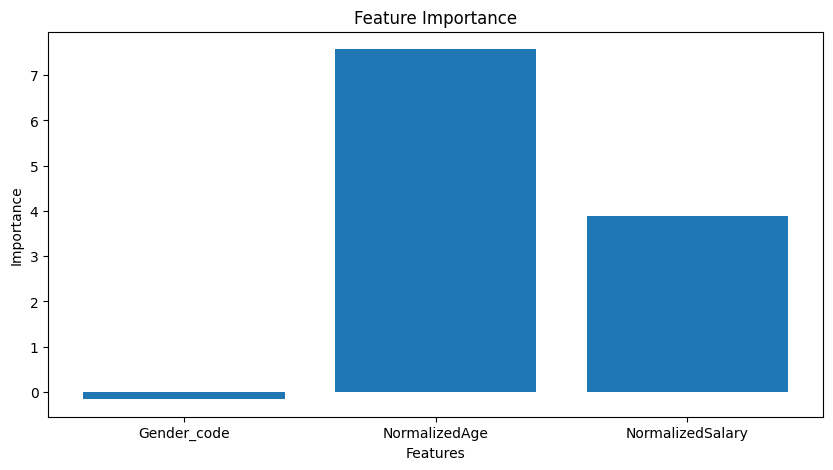

In [17]:
# Get feature importances from the model
feature_importance = model.coef_[0]

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importance)), feature_importance, tick_label=X.columns)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

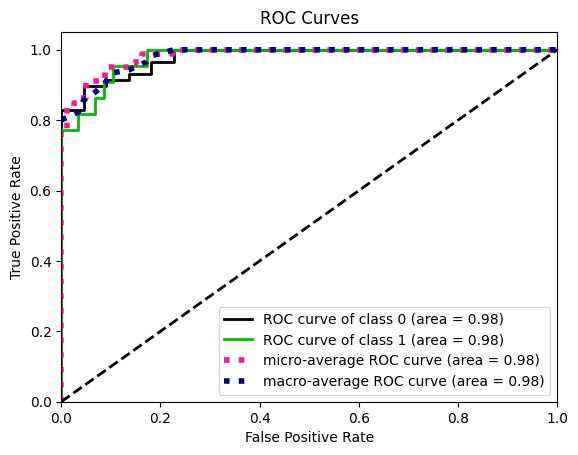

In [18]:
y_pred_proba = model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()

### Predict New Results

In [19]:
new_data = np.array([[0, 30, 90000], [1, 40, 120000]])
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(new_data)

In [ ]:
predicted_class = model.predict(normalized_data)
predicted_probabilities = model.predict_proba(normalized_data)

In [21]:
print("Person 1:", predicted_class[0], predicted_probabilities[0])
print("Person 2:", predicted_class[1], predicted_probabilities[1])

Person 1: 0 [0.99745906 0.00254094]
Person 2: 1 [0.00477346 0.99522654]
